In [7]:
from __future__ import print_function, division
import sys, os, time
import itertools
import copy
import warnings
import time
import math
# scientific computing libraries
import torch
import numpy as np
import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer

from scipy.sparse import coo_matrix, csc_matrix
import matplotlib.pyplot as plt
from scipy.interpolate import BPoly
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt

# third party libraries
import mosek
from tabulate import tabulate

from libott import loadTGP, construct_P, construct_A, gradient_from_P, gradient_from_A, set_print_level
from libbezier import Bezier

DO_PLOT_RESULTS = True


def print_green(*args, **kwargs):
    print("\033[1;32m", end='')
    print(*args, **kwargs)
    print("\033[0m", end='')

def print_yellow(*args, **kwargs):
    print("\033[1;33m", end='')
    print(*args, **kwargs)
    print("\033[0m", end ='')

def print_purple(*args, **kwargs):
    print("\033[1;34m", end='')
    print(*args, **kwargs)
    print("\033[0m", end='')

def print_red(*args, **kwargs):
    print("\033[1;35m", end='')
    print(*args, **kwargs)
    print("\033[0m", end='')

def print_cyan(*args, **kwargs):
    print("\033[1;36m", end='')
    print(*args, **kwargs)
    print("\033[0m", end='')

def print_gray(*args, **kwargs):
    print("\033[1;37m", end='')
    print(*args, **kwargs)
    print("\033[0m", end='')


class IndoorOptProblem(object):
    """Convex optimization around corridor approach for drone trajectory optimization.

    Currently it support problem where each corridor has been specified a time, later we will let it be free.
    """
    def __init__(self, tgp, tfweight=0, connect_order=2, verbose=False):
        """Constructor for this problem class.

        Parameters
        ----------
        tgp: a PyTGProblem object.
        tfweight: float, the weight on transfer time
        connect_order: to which order of derivative at connection do we guarantee continuity.
        verbose: bool, if the solver is verbose
        """
        self.floor = tgp  # I shall still use the floor name for convenience
        self.x0_pack = [tgp.position[0], tgp.velocity[0], tgp.acceleration[0]]
        self.xf_pack = [tgp.position[1], tgp.velocity[1], tgp.acceleration[1]]
        self.tfweight = tfweight
        self.obj_order = tgp.minimizeOrder
        self.poly_order = tgp.trajectoryOrder
        self.connect_order = connect_order  # guarantee acceleration continuity
        self.verbose = verbose
        self.margin = tgp.margin
        self.is_limit_vel = tgp.doLimitVelocity
        self.is_limit_acc = tgp.doLimitAcceleration
        self.vel_limit = tgp.maxVelocity  # component wise limit on velocity
        self.acc_limit = tgp.maxAcceleration  # component wise limit on acceleration
        # get info on environment
        self.boxes = tgp.getCorridor()
        self.num_box = len(self.boxes)
        self.room_time = np.array([box.t for box in self.boxes])
        bz = Bezier(self.poly_order, self.poly_order, self.obj_order)
        self.bz = bz
        self.bzM = self.bz.M()[self.poly_order]  # use this for some output stuff
        self.MQM = self.bz.MQM()[self.poly_order]
        self.h_type = "l"
        if verbose:
            print('has %d boxes' % self.num_box)
            print('init time ', self.room_time)
        # some default settings such as how close you can reach the corner
        self.abs_obj_tol = 1e-3  # this controls absolute objective tolerance and should not set small for problem with small obj
        self.rel_obj_tol = 5e-4  # this controls relative objective tolerance
        self.grad_tol = 1e-3  # this controls gradient tolerance
        self.r = 0.0001  # 0.00006 can converge
        self.w = 100


    def set_tfweight(self, weight):
        """Set weight on time"""
        self.tfweight = weight

    def construct_prob(self, x0_pack, xf_pack, poly_order, obj_order, connect_order):
        """Construct a problem."""
        pass

    def set_x0_pack_value(self, *args):
        """Set the contents of x0pack"""
        ff = zip(self.x0_pack, args)
        print(ff)
        for tmp, val in zip(self.x0_pack, args):
            tmp[:] = val[:]

    def set_xf_pack_value(self, *args):
        """Set the contents of xfpack"""
        for tmp, val in zip(self.xf_pack, args):
            tmp[:] = val[:]

    def solve_with_room_time(self, rm_time):
        """Specify room time and solve the problem"""
        raise NotImplementedError("Subclass should implement solve_with_room_time function")

    def get_output_coefficients(self, ):
        """
        Get the monomial coefficients representing a piece-wise polynomial trajectory
        return ndarray, (s, 1), time allocated for each segment 
        return ndarray, (s, o + 1, d), polynomial coefficients, where s is the number of segments, 
        o is the order of trajectory, d is the number of dimensions, which is 3
        """
        
        n_room = self.num_box
        
        poly_coef = np.zeros([n_room, self.poly_order + 1, 3])
        
        # coefficients in bezier and scaled form
        mat_x = np.reshape(self.sol, (n_room, 3, self.poly_order + 1))
        mat_x = np.transpose(mat_x, (0, 2, 1))

        # change coefficients to monomial and unscaled form
        for i in range(n_room):
            poly_coef[i, :, :] = self.bzM.dot(mat_x[i]) * self.room_time[i]

        return self.room_time.copy(), poly_coef

    def get_coef_matrix(self):
        """Return coefficients"""
        # self.sol = np.zeros((self.num_box*3*(self.poly_order + 1)))
        coef_mat = np.reshape(self.sol, (self.num_box, 3, self.poly_order + 1))
        coef_mat = np.transpose(coef_mat, (0, 2, 1))
        #import pdb; pdb.set_trace()
        for i in range(self.num_box):
            coef_mat[i] *= self.room_time[i]
        return coef_mat

    def get_coef_matrix2(self):
        """
        Return Bezier coefficients
        """
        # self.sol = np.zeros((self.num_box*3*(self.poly_order + 1)))
        coef_mat = np.reshape(self.sol, (self.poly_order + 1, 3, self.num_box), order='F')
        coef_mat = coef_mat.transpose((0,2,1))
        #import pdb;pdb.set_trace()
        for i in range(self.num_box):
            coef_mat[:,i,:] *= self.room_time[i]
        
        return coef_mat


    def from_coef_matrix(self, mat_in):
        """Assign values to sol based on the input coefficient matrix."""
        self.sol = np.zeros(mat_in.size)
        coef_mat = np.reshape(self.sol, (self.num_box, 3, self.poly_order + 1))
        for i in range(self.num_box):
            coef_mat[i] = mat_in[i].T / self.room_time[i]
        with np.printoptions(precision=4, linewidth=10000):
            print(self.sol)

    def get_output_path(self, n):
        """Get a path for output that is linspace in time.

        :param n: int, the number of nodes for a path
        :return: float, the total time for this problem
        :return: ndarray, (n, 2) the optimal path
        """
        cum_sum_time = np.cumsum(self.room_time)
        output = np.zeros((n, 3))  # the output trajectory
        sample_time = np.linspace(0, cum_sum_time[-1], n)
        n_room = self.num_box

        # get all the coef of polynomials
        t, all_poly_coeffs = self.get_output_coefficients()
        for i in range(n_room):
            # poly_coef = self.bzM.dot(mat_x[i]) * self.room_time[i]
            poly_coef = all_poly_coeffs[i,:,:]
            if i == 0:
                t_mask = sample_time <= cum_sum_time[0]
                use_s = sample_time[t_mask] / cum_sum_time[0]
            else:
                t_mask = (sample_time > cum_sum_time[i - 1]) & (sample_time <= cum_sum_time[i])
                use_s = (sample_time[t_mask] - cum_sum_time[i - 1]) / self.room_time[i]
            output[t_mask, 0] = np.polyval(poly_coef[:, 0][::-1], use_s)
            output[t_mask, 1] = np.polyval(poly_coef[:, 1][::-1], use_s)
            output[t_mask, 2] = np.polyval(poly_coef[:, 2][::-1], use_s)
        return cum_sum_time[-1], output

    def get_gradient(self):
        raise NotImplementedError

    def get_gradient_fd(self, h=1e-6):
        """Use forward finite difference to approximate gradients."""
        grad = np.zeros(self.num_box)
        obj0 = self.obj
        origin_time = self.room_time.copy()
        for i in range(self.num_box):
            try_time = origin_time.copy()
            try_time[i] += h
            self.solve_with_room_time(try_time)
            grad[i] = (self.obj - obj0) / h
        grad += self.tfweight
        return grad

    def get_gradient_mellinger(self, h=1e-6):
        """
        Use finite difference described in:
        http://www-personal.acfr.usyd.edu.au/spns/cdm/papers/Mellinger.pdf
        to approximate gradients.
        """
        grad = np.zeros(self.num_box)
        obj0 = self.obj
        origin_time = self.room_time.copy()
        for i in range(self.num_box):
            m = self.num_box
            gi = -1/(m-1) * np.ones(m)
            gi[i] = 1
            try_time = origin_time.copy()
            try_time += h * gi
            # print("In gg Mellinger: gi", gi," try_time: ", try_time)
            self.solve_with_room_time(try_time)
            grad[i] = (self.obj - obj0) / h
        grad += self.tfweight
        return grad

    def draw3D(self):
        # plot 3D trajectory
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        boxes = tgp.getCorridor()

        poly_coef = solver.get_coef_matrix().transpose((1,0,2))
        break_points = np.insert(np.cumsum(solver.room_time), 0, 0.0)
        initial_trajectory = BPoly(poly_coef, break_points)
        tt_initial = np.linspace(0.0, break_points[-1], 100)

        # poly_coef = solver.get_coef_matrix2()
        # final_trajectory = BPoly(poly_coef, break_points)
        # tt_final = np.linspace(0.0, break_points[-1], 100)

        from mpl_toolkits.mplot3d.art3d import Poly3DCollection



        def set_axes_equal(ax):
            '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
            cubes as cubes, etc..  This is one possible solution to Matplotlib's
            ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

            Input
            ax: a matplotlib axis, e.g., as output from plt.gca().
            '''

            x_limits = ax.get_xlim3d()
            y_limits = ax.get_ylim3d()
            z_limits = ax.get_zlim3d()

            x_range = abs(x_limits[1] - x_limits[0])
            x_middle = np.mean(x_limits)
            y_range = abs(y_limits[1] - y_limits[0])
            y_middle = np.mean(y_limits)
            z_range = abs(z_limits[1] - z_limits[0])
            z_middle = np.mean(z_limits)

            # The plot bounding box is a sphere in the sense of the infinity
            # norm, hence I call half the max range the plot radius.
            plot_radius = 0.5*max([x_range, y_range, z_range])

            ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
            ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
            ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

        for i in range(len(boxes)):
            vertices = boxes[i].vertex
            ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], s=1)
            Z = vertices            
            verts = [[Z[0],Z[1],Z[2],Z[3]],
                        [Z[4],Z[5],Z[6],Z[7]], 
                        [Z[0],Z[1],Z[5],Z[4]], 
                        [Z[2],Z[3],Z[7],Z[6]], 
                        [Z[1],Z[2],Z[6],Z[5]],
                        [Z[4],Z[7],Z[3],Z[0]], 
                        [Z[2],Z[3],Z[7],Z[6]]]

            # plot safe corridor
            pc = Poly3DCollection(verts, alpha = 0.0, facecolor='gray', linewidths=0.1, edgecolors='red')
            ax.add_collection3d(pc)

        ax.plot(initial_trajectory(tt_initial)[:,0], initial_trajectory(tt_initial)[:,1], initial_trajectory(tt_initial)[:,2], label="Before refinement")
        # ax.plot(final_trajectory(tt_final)[:,0], final_trajectory(tt_final)[:,1], final_trajectory(tt_final)[:,2], label="After refinement")

        ax.scatter(tgp.position[0,0], tgp.position[0,1], tgp.position[0,2], marker="*", s=20, label="Start")
        ax.scatter(tgp.position[1,0], tgp.position[1,1], tgp.position[1,2], marker="o", s=20, label="Goal")
        set_axes_equal(ax)
        ax.set_axis_off()
        ax.legend()
        ax.set_title("3D trajectory")

        """Formulate the indoor navigation problem explicitly as QP so we can either use mosek or osqp to solve it.

    I will manually maintain those matrices and hope it is more efficient.
    """


    def update_prob(self):
        """Just update the problem since we are changing pretty fast.

        This function assume you might have change in room sequence so it reconstructs things. Take care with this.
        """
        self.construct_prob(self.x0_pack, self.xf_pack, self.poly_order, self.obj_order, self.connect_order)

    def construct_prob(self, x0_pack, xf_pack, poly_order, obj_order, connect_order):
        """Construct a problem."""
        # construct the problem using Fei's code
        # self.construct_P()
        self.construct_A()

    def construct_P(self):
        # P is fixed and we do not alter it afterwards, so let's keep going

        pval, prow, pcol = construct_P(self.obj_order, self.num_box, self.poly_order, self.room_time, self.MQM, self.h_type)
        self.sp_P = coo_matrix((pval, (prow, pcol)))  # ugly hack since osqp only support upper triangular part or full
        self.n_var = self.sp_P.shape[0]
        # self.qp_P = spmatrix(sp_P.data, sp_P.row, sp_P.col)
        self.qp_q = np.zeros(self.n_var)

    def construct_A(self):
        lincon = construct_A(
                self.floor.getCorridor(),
                self.MQM,
                self.floor.position.copy(order='F'),
                self.floor.velocity.copy(order='F'),
                self.floor.acceleration.copy(order='F'),
                self.floor.maxVelocity,
                self.floor.maxAcceleration,
                self.floor.trajectoryOrder,
                self.floor.minimizeOrder,
                self.floor.margin,
                self.floor.doLimitVelocity,
                self.floor.doLimitAcceleration)
        self.xlb = lincon.xlb
        self.xub = lincon.xub
        self.clb = lincon.clb
        self.cub = lincon.cub
        # we need more
        self.sp_A = coo_matrix((lincon.aval, (lincon.arow, lincon.acol)))
        self.n_con = self.sp_A.shape[0]
        if self.verbose > 1:
            print('n_con', self.n_con)
            print('n_var', self.sp_A.shape[1])
            print("A has %d nnz" % lincon.aval.shape[0])

    def eval_cost_constr(self, mat_in):
        """Pass in a coefficient matrix, see results."""
        self.from_coef_matrix(mat_in)  # update self.sol
        self.update_prob()
        cost = 0.5 * self.sol.dot(self.sp_P.dot(self.sol))
        Ax = self.sp_A.dot(self.sol)
        # equality part
        error_clb = np.minimum(Ax - self.clb, 0)
        error_cub = np.minimum(-Ax + self.cub, 0)
        error_lb = np.minimum(self.sol - self.xlb, 0)
        error_ub = np.minimum(self.xub - self.sol, 0)
        with np.printoptions(precision=4, linewidth=10000):
            print('cost %f' % cost)
            print('error_eq', np.minimum(error_clb, error_cub))
            print('error_ieq', np.minimum(error_lb, error_ub))

    def get_gradient(self, sol, lmdy, lmdz):
        pgrad = gradient_from_P(self.obj_order, self.num_box, self.poly_order, self.room_time, self.MQM, sol)
        agrad = gradient_from_A(
                    self.floor.getCorridor(),
                    self.MQM,
                    self.floor.position.copy(order='F'),
                    self.floor.velocity.copy(order='F'),
                    self.floor.acceleration.copy(order='F'),
                    self.floor.maxVelocity,
                    self.floor.maxAcceleration,
                    self.floor.trajectoryOrder,
                    self.floor.minimizeOrder,
                    self.floor.margin,
                    self.floor.doLimitVelocity,
                    self.floor.doLimitAcceleration,
                    sol,
                    lmdy,
                    lmdz)
        if self.verbose > 1:
            print('pgrad', pgrad)
            print('agrad', agrad)
        return pgrad + agrad + self.tfweight

    def solve_once(self):
        """Solve the original problem once."""
        raise NotImplementedError
    

    def solve_with_room_time(self, rm_time): ###new candidate time y
        self.room_time[:] = rm_time
        self.floor.updateCorridorTime(self.room_time)
        return self.solve_once()
    
        

    def Monopoly(self, alpha0=0.02, h=1e-5, c=0.2, tau=0.2, max_iter=5000, j_iter=5, log=False, timeProfile=False, adaptiveLineSearch=False):
        """Use backtrack line search to refine time. We fix total time to make things easier.

        Parameters
        ----------
        alpha0: float, initial step length 0.175 and 0.375 are found to be very good.
        h: float, step size for finding gradient using forward differentiation
        c: float, the objective decrease parameter
        tau: float, the step length shrink parameter
        max_iter: int, maximum iteration for gradient descent
        j_iter: int, maximum iteration for finding alpha
        abs_tol: float, absolute objective tolerance
        rel_tol: float, Relative objective tolerance
        Returns
        -------
        is_okay: bool, indicates if some exception occurs
        converged: bool, indicates if the algorithm converges
        """

        if log == True:
            self.log = np.array([])
            self.log = np.append(self.log, [self.obj, 0])

        if timeProfile == True:
            self.timeProfile = np.array([])

        t0 = time.time()
        self.major_iteration = 0
        self.num_prob_solve = 0
        if self.num_box == 1 and self.tfweight == 0:
            self.major_iteration = 0
            self.num_prob_solve = 0
            self.time_cost = time.time() - t0
            self.converge_reason = 'No need to refine'
            return True, True
        n_room = self.num_box
        # t_now = self.room_time.copy()
        y = torch.from_numpy(self.room_time)
        y.requires_grad_()

        converged = False
        converge_reason = 'Not converged'
        num_prob_solve = 0  # record number of problems being solved for a BTLS
        T = 3
        dim = 3*self.num_box*(self.poly_order+1)
        # c_0 = torch.zeros(dim, dtype=torch.double,requires_grad=True)
        c_0 = torch.tensor(dim*[0], dtype=torch.double,requires_grad=True)


        obj = torch.zeros(1, dtype=torch.double,requires_grad=True)
        for i in range(max_iter):
            y.requires_grad_()
            if self.verbose:
                print_green('Iteration %d' % i)
           
            obj0 = obj
            is_okay = True
            
            if timeProfile == True:
                tBeforeGrad = time.time()

            self.floor.updateCorridorTime(y.detach().numpy())
            IndoorOptProblem.update_prob(self) #update y for c
            c = c_0
            qval, qrow, qcol = Hierarchy_free.construct_P_matrix(self.obj_order, self.num_box, self.poly_order, y, self.MQM, self.h_type)
            # p_y = torch.sparse_coo_tensor((qrow, qcol), qval).to_sparse_csr()
            # p_y = torch.sparse_coo_tensor((qrow, qcol), qval).to_dense()
            # pp = torch.sparse_coo_tensor((qrow, qcol), qval)
            p_y = torch.sparse_coo_tensor((qrow, qcol), qval).to_dense()

            # p_y = pp.to_dense()
            p_y = p_y + p_y.t() - torch.diag(p_y.diagonal())
            #y = torch.from_numpy(self.room_time)
            #y.requires_grad_()
            
            i = 0
            while i < T:
                c = Hierarchy_free.h(self, p_y, y, c)
                i += 1
    
            # print(np.shape(Hierarchy_free.solve_Jacobian(y,c))) 
             
            obj = Hierarchy_free.l(self, p_y, y, c)
            print(obj)
            obj.backward()  
            grad = y.grad.detach().numpy()

            candidit_y= y.detach().numpy()
            # choose a method to calculate gradient
            # if self.grad_method == 'ours':
            #     grad = y.grad
            # elif self.grad_method == 'fd':
            #     grad = self.get_gradient_fd(h=0.25*1e-6)
            # elif self.grad_method == 'mel':
            #     grad = self.get_gradient_mellinger(h=0.25*1e-6)
            # else:
            #     print_red("No this grad method!")
            
            if timeProfile == True:
                tAfterGrad = time.time()
                self.timeProfile = np.append(self.timeProfile, [tAfterGrad - tBeforeGrad])

            #print_red('grad_an ', grad, ' grad_fd ', grad_fd, 'grad_mel', grad_mel)
            if self.tfweight == 0:
                # get projected gradient, the linear manifold is \sum x_i = 0; if tfweight=0, we fix total time
                normal = np.ones(n_room) / np.sqrt(n_room) # normal direction
                grad = grad - grad.dot(normal) * normal  # projected gradient descent direction
            # print_red('grad_an ', grad / np.linalg.norm(grad), ' grad_fd ', grad_fd / np.linalg.norm(grad_fd), 'grad_mel', grad_mel / np.linalg.norm(grad_mel))
            # print_yellow('sum_an ', np.sum(grad), 'sum_fd ', np.sum(grad_fd), 'sum_mel ', np.sum(grad_mel))
            if np.linalg.norm(grad) < self.grad_tol:  # break out if gradient is too small
                if self.verbose:
                    print('Gradient too small')
                converged = True
                converge_reason = 'Small gradient'
                break
            if self.verbose:
                print_green('At time ', candidit_y, ' grad is ', grad)
            m = -np.linalg.norm(grad)
            p = grad / m  # p is the descending direction
            # use a maximum alpha that makes sure time are always positive
            alpha_max = np.amax(-candidit_y / p) - 1e-6  # so I still get non-zero things
            if alpha_max > 0:
                alpha = min(alpha_max, alpha0)
            else:
                alpha = alpha0
            # t = -c * m

            # find alpha
            alpha_found = False

            if timeProfile == True:
                tBeforeAlpha = time.time()

            for j in range(j_iter):
                if self.verbose:
                    print('Search alpha step %d, alpha = %f' % (j, alpha))
                candidit_y = candidit_y + alpha * p

                # lower bound on the alpha
                if adaptiveLineSearch == True:
                    if alpha < 1e-4:
                        if self.verbose:
                            print_yellow('Stop line search because alpha is too small')
                        break
                
                # make sure that time will not go too small
                if np.any(candidit_y < 1e-6):
                    alpha = tau * alpha
                    continue
                alpha_found = True
                break
                

            if timeProfile == True:
                tAfterAlpha = time.time()
                self.timeProfile = np.append(self.timeProfile, [tAfterAlpha - tBeforeAlpha])

            if self.verbose:
                if alpha_found:
                    print('We found alpha = %f' % alpha)
                else:
                    print('Fail to find alpha, use a conservative %f' % alpha)
            if not alpha_found:  # for case where alpha is not found
                converge_reason = 'Cannot find step size alpha'
                is_okay = True
                converged = False
                # roll back to t_now
                self.room_time = candidit_y
                if log == True:
                    duration = time.time() - t0
                    self.log = np.append(self.log, [obj0, duration])
                break

            # adaptive line search

            # ready to update time now and check convergence
            with torch.no_grad():
                beta = 0.0001
                y = torch.from_numpy(candidit_y)
                c_pre = c_0
                c_0 -= beta * c_0.grad
            # y.grad.zero_()
            # this is the alpha we desire
            if self.verbose:
                print('obj0 = ', obj0, 'obj = ', obj)
            if log == True:
                duration = time.time() - t0
                # we log the objective and duration for each major iteration
                if self.verbose == True:
                    print("Logging: obj: %f, T: %f" % (obj, duration))
                self.log = np.append(self.log, [obj, duration])
            if abs(obj - obj0) < self.abs_obj_tol:
                if self.verbose:
                    print('Absolute obj improvement too small')
                converged = True
                converge_reason = 'Absolute cost'
                break
            elif abs(obj - obj0) / abs(obj0) < self.rel_obj_tol:
                if self.verbose:
                    print('Relative obj improvement too small')
                converged = True
                converge_reason = 'Relative cost'
                break
        self.major_iteration = i
        self.num_prob_solve = num_prob_solve
        self.time_cost = time.time() - t0
        self.converge_reason = converge_reason
        return is_okay, converged


    def Cournot(self, alpha0=0.001, h=1e-5, c=0.2, tau=0.1, max_iter=1000, j_iter=50, log=False, timeProfile=False, adaptiveLineSearch=False):
        """Use backtrack line search to refine time. We fix total time to make things easier.

        Parameters
        ----------
        alpha0: float, initial step length 0.175 and 0.375 are found to be very good.
        h: float, step size for finding gradient using forward differentiation
        c: float, the objective decrease parameter
        tau: float, the step length shrink parameter
        max_iter: int, maximum iteration for gradient descent
        j_iter: int, maximum iteration for finding alpha
        abs_tol: float, absolute objective tolerance
        rel_tol: float, Relative objective tolerance
        Returns
        -------
        is_okay: bool, indicates if some exception occurs
        converged: bool, indicates if the algorithm converges
        """

        if log == True:
            self.log = np.array([])
            self.log = np.append(self.log, [self.obj, 0])

        if timeProfile == True:
            self.timeProfile = np.array([])

        t0 = time.time()

        self.major_iteration = 0
        self.num_prob_solve = 0
        if self.num_box == 1 and self.tfweight == 0:
            self.major_iteration = 0
            self.num_prob_solve = 0
            self.time_cost = time.time() - t0
            self.converge_reason = 'No need to refine'
            return True, True
        n_room = self.num_box
        # t_now = self.room_time.copy()
        y = torch.tensor(self.room_time, dtype=torch.double) #, dtype = torch.double

        y.requires_grad_()

        converged = False
        converge_reason = 'Not converged'
        num_prob_solve = 0  # record number of problems being solved for a BTLS
        T = 500
        dim = 3*self.num_box*(self.poly_order+1)
        # c_0 = torch.zeros(dim, dtype=torch.double,requires_grad=True)
        c_0 = torch.tensor(dim*[0], dtype=torch.double,requires_grad=True)
        self.floor.updateCorridorTime(y.detach().numpy())
        IndoorOptProblem.update_prob(self) #update y for c
        # c_0 = torch.tensor([(self.xlb+self.xub)/2], dtype=torch.double,requires_grad=True)

        
        # print("test:"+str(Hierarchy_free.l(self, p_y, y, c_0)))
        # print(p_y)
        obj = torch.zeros(1, dtype=torch.double,requires_grad=True)
        for k in range(max_iter):
            if self.verbose:
                print_green('Iteration %d' % i)
           
            obj0 = obj
            is_okay = True
            
            if timeProfile == True:
                tBeforeGrad = time.time()
            
            # y = torch.tensor([3.80504758, 1.14997985, 0.83818007],dtype=torch.double)
            y.requires_grad_()
            self.floor.updateCorridorTime(y.detach().numpy())
            IndoorOptProblem.update_prob(self) #update y for c

            c = c_0
            # tt = time.time()
            qval, qrow, qcol = Hierarchy_free.construct_P_matrix(self.obj_order, self.num_box, self.poly_order, y, self.MQM, self.h_type) # time cost: 0.03
            # print(time.time()-tt)
            
            # tt = time.time() 
            p_y = torch.sparse_coo_tensor((qrow, qcol), qval).to_dense()   # time cost: 0.03
            # print(time.time()-tt)
            #print("hello world: " ,qrow)
            # p_y = pp.to_dense()
            p_y = p_y + p_y.t() - torch.diag(p_y.diagonal())

            i = 0
            while i < T:
                # tt = time.time()
                c = Hierarchy_free.h(self, p_y, y, c)    # time cost: 0.05
                # print(time.time()-tt)          
                i += 1
            
             
            obj = Hierarchy_free.l(self, p_y, y, c)
            # print("obj:")
            print(obj)
            self.sol = c.detach().numpy()
            self.room_time = y.detach().numpy()
            if(k==0):
                IndoorOptProblem.draw3D(self)
            obj.backward()  
            grad = y.grad.detach().numpy()

            candidit_y= y.detach().numpy()
            # choose a method to calculate gradient
            # if self.grad_method == 'ours':
            #     grad = y.grad
            # elif self.grad_method == 'fd':
            #     grad = self.get_gradient_fd(h=0.25*1e-6)
            # elif self.grad_method == 'mel':
            #     grad = self.get_gradient_mellinger(h=0.25*1e-6)
            # else:
            #     print_red("No this grad method!")
            
            if timeProfile == True:
                tAfterGrad = time.time()
                self.timeProfile = np.append(self.timeProfile, [tAfterGrad - tBeforeGrad])

            #print_red('grad_an ', grad, ' grad_fd ', grad_fd, 'grad_mel', grad_mel)
            if self.tfweight == 0:
                # get projected gradient, the linear manifold is \sum x_i = 0; if tfweight=0, we fix total time
                normal = np.ones(n_room) / np.sqrt(n_room) # normal direction
                grad = grad - grad.dot(normal) * normal  # projected gradient descent direction
            # print_red('grad_an ', grad / np.linalg.norm(grad), ' grad_fd ', grad_fd / np.linalg.norm(grad_fd), 'grad_mel', grad_mel / np.linalg.norm(grad_mel))
            # print_yellow('sum_an ', np.sum(grad), 'sum_fd ', np.sum(grad_fd), 'sum_mel ', np.sum(grad_mel))
            if np.linalg.norm(grad) < self.grad_tol:  # break out if gradient is too small
                if self.verbose:
                    print('Gradient too small')
                converged = True
                converge_reason = 'Small gradient'
                break
            if self.verbose:
                print_green('At time ', candidit_y, ' grad is ', grad)
            m = np.linalg.norm(grad)
            # print(m)
            p = grad / m  # p is the descending direction
            # use a maximum alpha that makes sure time are always positive
            # alpha_max = np.amax(-candidit_y / p) - 1e-6  # so I still get non-zero things
            
            alpha = alpha0
            # t = -c * m

            # find alpha
            alpha_found = False

            if timeProfile == True:
                tBeforeAlpha = time.time()

            for j in range(j_iter):
                if self.verbose:
                    print('Search alpha step %d, alpha = %f' % (j, alpha))
                #candidit_y = y.detach().numpy() - alpha/math.sqrt(k+1) * p
                candidit_y = y.detach().numpy() - alpha * grad / math.sqrt(m)
                # lower bound on the alpha
                if adaptiveLineSearch == True:
                    if alpha < 1e-4:
                        if self.verbose:
                            print_yellow('Stop line search because alpha is too small')
                        break
                
                # make sure that time will not go too small
                if np.any(candidit_y < 1e-6):
                    print("line search")
                    alpha = tau * alpha
                    continue
                alpha_found = True
                break

            if timeProfile == True:
                tAfterAlpha = time.time()
                self.timeProfile = np.append(self.timeProfile, [tAfterAlpha - tBeforeAlpha])

            if self.verbose:
                if alpha_found:
                    print('We found alpha = %f' % alpha)
                else:
                    print('Fail to find alpha, use a conservative %f' % alpha)
            if not alpha_found:  # for case where alpha is not found
                converge_reason = 'Cannot find step size alpha'
                is_okay = True
                converged = False
                # roll back to t_now
                self.room_time = candidit_y
                if log == True:
                    duration = time.time() - t0
                    self.log = np.append(self.log, [obj0, duration])
                break

            # adaptive line search

            # ready to update time now and check convergence
            with torch.no_grad():
                c_0 = Hierarchy_free.h(self, p_y, y, c)
                y = torch.from_numpy(candidit_y)
            # y.grad.zero_()
            # this is the alpha we desire
            if self.verbose:
                print('obj0 = ', obj0, 'obj = ', obj)
            if log == True:
                duration = time.time() - t0
                # we log the objective and duration for each major iteration
                if self.verbose == True:
                    print("Logging: obj: %f, T: %f" % (obj, duration))
                self.log = np.append(self.log, [obj, duration])
            if abs(obj - obj0) < self.abs_obj_tol:
                if self.verbose:
                    print('Absolute obj improvement too small')
                converged = True
                converge_reason = 'Absolute cost'
                break
            elif abs(obj - obj0) / abs(obj0) < self.rel_obj_tol:
                if self.verbose:
                    print('Relative obj improvement too small')
                converged = True
                converge_reason = 'Relative cost'
                break
            k += 1
        self.major_iteration = i
        self.num_prob_solve = num_prob_solve
        self.time_cost = time.time() - t0
        self.converge_reason = converge_reason
        return is_okay, converged, converge_reason

    


    
class IndoorQPProblemMOSEK(IndoorOptProblem):
    """Use mosek solver to solve this problem in cvxopt interface or not"""
    def __init__(self, tgp, tfweight=0, connect_order=2, verbose=False):
        IndoorOptProblem.__init__(self, tgp, tfweight, connect_order, verbose)
        self.h_type = "L"

    def solve_once(self):

        self.update_prob()

        # set up A
        A_sp = self.sp_A.tocsc()
        colptr, asub, acof = A_sp.indptr, A_sp.indices, A_sp.data
        aptrb, aptre = colptr[:-1], colptr[1:]
        # set up bounds on x
        bkx = self.n_var * [mosek.boundkey.ra]
        bkc = self.n_con * [mosek.boundkey.ra]
        with mosek.Env() as env:
            with env.Task(0, 1) as task:
                task.inputdata(self.n_con, self.n_var, self.qp_q.tolist(), 0.0,
                                list(aptrb), list(aptre), list(asub), list(acof),
                                bkc, self.clb.tolist(), self.cub.tolist(), 
                                bkx, self.xlb.tolist(), self.xub.tolist()
                                )
                # set up lower triangular part of P
                task.putqobj(self.sp_P.row.tolist(), self.sp_P.col.tolist(), self.sp_P.data.tolist())
                task.putobjsense(mosek.objsense.minimize)
                task.optimize()
                solsta = task.getsolsta(mosek.soltype.itr)
                x = self.n_var * [0.0]
                task.getsolutionslice(mosek.soltype.itr, mosek.solitem.xx, 0, self.n_var, x)
                x = np.array(x)
                # get dual variables on linear constraints
                zu, zl = self.n_con * [0.0], self.n_con * [0.0]
                task.getsolutionslice(mosek.soltype.itr, mosek.solitem.suc, 0, self.n_con, zu)
                task.getsolutionslice(mosek.soltype.itr, mosek.solitem.slc, 0, self.n_con, zl)
                z = np.array(zu) - np.array(zl)
                # get dual variables on variable bounds
                yu, yl = self.n_var * [0.0], self.n_var * [0.0]
                task.getsolutionslice(mosek.soltype.itr, mosek.solitem.sux, 0, self.n_var, yu)
                task.getsolutionslice(mosek.soltype.itr, mosek.solitem.slx, 0, self.n_var, yl)
                y = np.array(yu) - np.array(yl)
                if self.verbose:
                    print("Solving status", solsta)
                if solsta == mosek.solsta.optimal: #solsta == mosek.solsta.near_optimal: near_optimal is longer valid in Mosek 9.0
                    self.is_solved = True
                    self.obj = task.getprimalobj(mosek.soltype.itr) + self.tfweight * np.sum(self.room_time)
                    self.sol = x
                    self.lmdy = z
                    self.lmdz = y
                    return solsta, x, z, y
                else:
                    self.is_solved = False
                    self.obj = np.inf
                    #print("Mosek Failed, solsta: ", solsta)
                    return solsta, None, None, None
                
class Hierarchy_free(IndoorOptProblem):
    """Use mosek solver to solve this problem in cvxopt interface or not"""
    def __init__(self, tgp, tfweight=0, connect_order=2, verbose=False):
        IndoorOptProblem.__init__(self, tgp, tfweight, connect_order, verbose)
        
    def construct_P_matrix(minimize_order, segment_num, poly_order, room_time, MQM, ptype):
        min_order_l = int(np.floor(minimize_order))
        min_order_u = int(np.ceil(minimize_order))

        NUMQNZ = 0
        NUMQ_blk = poly_order + 1  # default minimize the jerk and minimize_order = 3
        if ptype.lower() == "f":
            NUMQNZ = segment_num * 3 * (NUMQ_blk ** 2)
        else:
            NUMQNZ = segment_num * 3 * NUMQ_blk * (NUMQ_blk + 1) / 2

        qval = torch.zeros(int(NUMQNZ),dtype=torch.double)
        qsubi = np.zeros(int(NUMQNZ),dtype=int)
        qsubj = np.zeros(int(NUMQNZ),dtype=int)
        
        sub_shift = 0
        idx = 0
        s1d1CtrlP_num = poly_order + 1
        s1CtrlP_num = 3 * s1d1CtrlP_num

        for k in range(segment_num):
            scale_k = room_time[k]
            for p in range(3):
                for i in range(s1d1CtrlP_num):
                    for j in range(s1d1CtrlP_num):
                        if ((ptype.lower() == "l" and i >= j) or (ptype.lower() == "u" and i <= j) or ptype.lower() == "f"):
                            qsubi[idx] = sub_shift + p * s1d1CtrlP_num + i
                            qsubj[idx] = sub_shift + p * s1d1CtrlP_num + j

                            if min_order_l == min_order_u:
                                qval[idx] = MQM[i][j] / (scale_k ** (2 * min_order_u - 3))
                            else:
                                qval[idx] = ((minimize_order - min_order_l) / (scale_k ** (2 * min_order_u - 3)) +
                                            (min_order_u - minimize_order) / (scale_k ** (2 * min_order_l - 3))) * MQM[i][j]
                            idx += 1

            sub_shift += s1CtrlP_num
        # p_coomatrix = torch.sparse_coo_tensor((qsubi, qsubj), qval)
        # return p_coomatrix.to_dense()
        return qval, qsubi, qsubj

    # def df(self, p_y, c): # derivative of lower-level cost with respect to variable c
    #     return 2 * p_y @ c
    
    # def l(self, p_y, y, c):  # loss fsunction

    #     return torch.dot(c, p_y @ c) #   + sum(torch.tensor(self.tfweight)* y)


    def df(self, p_y, y, c): # derivative of lower-level cost with respect to variable c
        sp_A = torch.from_numpy(self.sp_A.toarray())
        clb = self.clb
        result = 2*p_y @ c.T + 2 * self.w *(sp_A.T @ sp_A @ c.T -sp_A.T @ clb.T)  # 0.0001

        # print(2*p_y @ c.T)
        # print(2 * self.w *(sp_A.T @ sp_A @ c.T -sp_A.T @ clb.T)) This part is almost 0
        return result
    
    def l(self, p_y, y, c):  # loss function
        sp_A = torch.from_numpy(self.sp_A.toarray())
        clb = torch.from_numpy(self.clb)
        return 0.5 * c @ (p_y@c.T) + self.w * torch.norm(sp_A @ c.T - clb)**2
    
    def h(self, p_y, y, c):  # solving lower-level problem c

        # dim = 3*self.num_box*(self.poly_order+1)
        # c_var = cp.Variable(dim)
        # b_par = cp.Parameter(dim)
        # sp_A = torch.from_numpy(self.sp_A.toarray())
        # clb = torch.from_numpy(self.clb)
        # # constraints = [self.sp_A @ c_var == self.clb, c_var<=self.xub, c_var>=self.xlb]  #
        # constraints = [sp_A @ c_var.T == clb, c_var<=self.xub, c_var>=self.xlb]
        # objective = cp.Minimize(cp.pnorm(c_var - b_par, p=2))
        # problem = cp.Problem(objective, constraints)
        # assert problem.is_dpp()
        # # v = time.time()
        # f = Hierarchy_free.df(self, p_y, y, c).T
        # b = c - self.r * f /(torch.sum(abs(f))+1)
        # #b = c - self.r * f
        # # print("norm_f:")
        # # print(torch.sum(abs(f)))    #/ torch.sum(abs(f))
        # # print("time df:"+str(time.time()-v))
        # # v = time.time()
        # cvxpylayer = CvxpyLayer(problem, parameters=[b_par], variables=[c_var])
        # # print("time cvlayer:"+str(time.time()-v))
        # c = cvxpylayer(b)[0]
        # tt = time.time()
        f = Hierarchy_free.df(self, p_y, y, c).T  # time cost: 0.03
        #print(time.time()-tt)
        # tt = time.time()
        b = c- self.r * f /math.sqrt((torch.sum(abs(f))+1)) # time cost: 7e^-5
        # print(time.time()-tt)
        xlb = torch.from_numpy(self.xlb)  # time cost: e^-6
        xub = torch.from_numpy(self.xub)
        
        b = torch.min(torch.max(b,xlb),xub)  # time cost: e^-5

        #obj = Hierarchy_free.l(self, p_y, y, c)  # time cost: 7e^-5
        #print(time.time()-tt)
        #print("obj:", obj)
        
        return b




"""Test the backtrack line search with IP solver."""
prob = 18  # problem 11 has a small dimension so its more fast, optimise the speed on problem 18

tgp = loadTGP('dataset/tgp_%d.tgp' % prob)  # every time you have to reload from hard disk since it is modified before
initial_time_allocation = np.array([box.t for box in tgp.getCorridor()])
    
# we do not limit velocity in the open source implementation
tgp.doLimitVelocity = False
# we minimize jerk
tgp.minimizeOrder = 3
# we use 6-th order piecewise Bezier spline
tgp.trajectoryOrder = 6
    
#print_green("Use Mosek + Adaptive line search")
    
solver = IndoorOptProblem(tgp, verbose=False)
    



In [ ]:
solver.

tensor(16548.3037, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11852.7429, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9730.3136, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8151.1884, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6881.8064, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5946.0999, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5157.6245, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4547.1145, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4032.4628, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3610.1499, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3252.2240, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2945.5656, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2679.9103, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2447.6781, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2242.6392, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2059.0579, dtype=torch.float64, grad_fn=<AddBa

(True, True, 'Absolute cost')

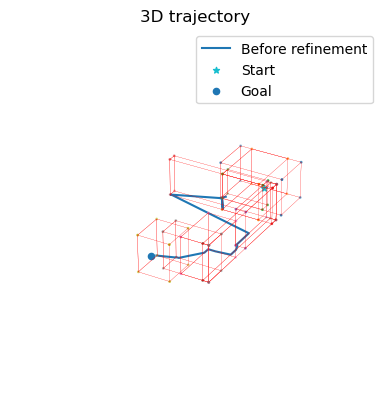

In [8]:
solver.Cournot()

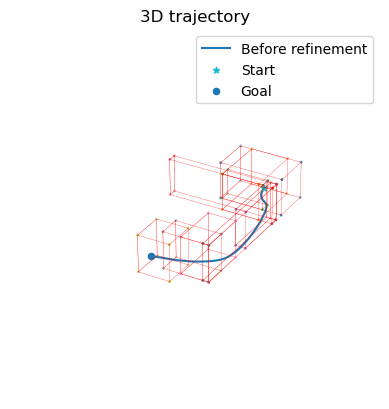

In [9]:
solver.draw3D()
